In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-challenge-2025-rnp/sample_submission.csv
/kaggle/input/data-challenge-2025-rnp/train.csv
/kaggle/input/data-challenge-2025-rnp/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/data-challenge-2025-rnp/train.csv")

In [3]:
# Normalize rtts for this test
import ast
def normalize_rtts(s):
    try:
        values = ast.literal_eval(s)   # parse "[...]" into a Python list
        if isinstance(values, (list, tuple)):
            return float(np.mean(values))  # mean if multiple, just the value if one
        else:
            return np.nan
    except Exception:
        return np.nan

In [4]:
df["seconds_since_last_sample"] = df.groupby(["tr_dst", "tr_src"])["seconds_since_start"].diff().fillna(0)

# Filtering only rows with some time between samples as majority of 

# df = df[df["seconds_since_last_sample"] > 0]


In [5]:
# df = df.sort_values(["tr_dst", "tr_src", "seconds_since_start"]).reset_index(drop=True)


df["norm_rtts"] = [normalize_rtts(x) for x in df["all_rtts"]]
df = df.drop("all_rtts", axis=1)

In [6]:
# Enriching with more columns

df["rtts_diff"] = df.groupby(["tr_dst", "tr_src"])["norm_rtts"].diff().abs().fillna(0)
df["rtts_diff_norm"] = df["rtts_diff"] / df["norm_rtts"]
df['rtts_mean_5'] = df.groupby(['tr_src','tr_dst'])['norm_rtts'].rolling(5, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df['rtts_dist_from_mean_5'] = (df["rtts_mean_5"] - df["norm_rtts"]).abs()
df['rtts_mean'] = df.groupby(['tr_src','tr_dst'])['norm_rtts'].transform('mean')
df['rtts_dist_from_mean'] = (df["rtts_mean"] - df["rtts_diff"]).abs()



In [7]:
print(len(df[df["route_changed"] == 1]))
print(len(df[df["route_changed"] == 0]))

369570
19595589


In [8]:
df['rtts_std'] = df.groupby(['tr_src', 'tr_dst'])['norm_rtts'].transform('std')
df['rtts_zscore'] = (df['norm_rtts'] - df['rtts_mean']) / (df['rtts_std'] + 1e-8)

df['rtts_rolling_std'] = df.groupby(['tr_src', 'tr_dst'])['norm_rtts'].transform(
    lambda x: x.rolling(window=10, min_periods=1).std()
)
# Preencher NaN com 0 e substituir zeros por um valor mínimo
df['rtts_rolling_std'] = df['rtts_rolling_std'].fillna(0)
df['rtts_rolling_std'] = df['rtts_rolling_std'].replace(0, df['rtts_rolling_std'][df['rtts_rolling_std'] > 0].min() if (df['rtts_rolling_std'] > 0).any() else 0.001)

df['rtts_sudden_change'] = (df['rtts_diff'] > df['rtts_rolling_std'] * 2).astype(int)

df["ratio_replies_probes"] = df["total_replies_last_hop"]  / df["total_probes_sent"]

# Calcula a distância absoluta de 1
df['ratio_dist1'] = np.abs(df['ratio_replies_probes'] - 1)

# Inverte para que valores próximos de 1 tenham maior valor
df['ratio_mono_dist1'] = 1 / (1 + df['ratio_dist1'])

In [9]:
route_stats = df.groupby(['tr_dst','tr_src'])['route_changed'].mean().rename('route_change_rate')
df = df.merge(route_stats, on=['tr_dst','tr_src'])


# changed = df[df["route_changed"] == 1]
# unchanged = df[df["route_changed"] == 0]

# percentiles = np.arange(0.02, 1.00, 0.02)

In [10]:
# current_var_name = "rtts_dist_from_mean"
# current_var = df[current_var_name]

# from scipy.stats import pointbiserialr

# current_var.describe()

# corr, pval = pointbiserialr(current_var, df["route_changed"])
# print("Correlação:", corr, "p-valor:", pval)

# from sklearn.feature_selection import mutual_info_classif

# mi = mutual_info_classif(df[[current_var_name]], df["route_changed"])
# print("Mutual Information:", mi[0])

# changed = df[df["route_changed"] == 1]
# unchanged = df[df["route_changed"] == 0]

# print(df[current_var_name].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

# print("Describe changed")
# print(changed[current_var_name].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

# print("Describe changed")
# print(changed[current_var_name].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

In [11]:
# # bins = np.arange(current_var.min(), current_var.max(), 0.5)

# bins = np.arange(0, 1.00, 0.05)
# bins = np.concatenate((bins, np.logspace(0, np.log10(current_var.max()), num=10)), axis=0)

# ratio_list = []

# for i in range(1, len(bins)):
#     div = df[(current_var <= bins[i]) & (current_var > bins[i-1])]
#     ratio = max((div["route_changed"] == 1).sum(), 1) / max((div["route_changed"] == 0).sum(), 1)
#     ratio_list.append(ratio)

# x_pos = np.arange(len(bins) - 1)

# plt.figure(figsize=(10,6))
# plt.bar(x_pos, ratio_list, width=0.6, color='skyblue', edgecolor='black')
# plt.xticks(x_pos, [f'<{b:.2f}' for b in bins[1:]], rotation=45)
# plt.xlabel('Bins current_var')
# plt.ylabel('Ratio route_changed=1 / route_changed=0')
# plt.title('Ratio por bin de current_var')
# plt.tight_layout()
# plt.show()

In [12]:
features = ["rtts_diff_norm", "rtts_diff", "seconds_since_last_sample", "route_change_rate", "ratio_mono_dist1", "rtts_dist_from_mean", "rtts_dist_from_mean_5", "rtts_zscore", 'rtts_sudden_change']

X = df[features]

y = df["route_changed"]

In [13]:
# import optuna
# import xgboost as xgb
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# def objective_f1_balanced(trial):
#     """
#     Otimização direta para F1-Score com classes quase balanceadas
#     """
#     params = {
#         "objective": "binary:logistic",
#         "eval_metric": "logloss",
#         "seed": 42,
#         "tree_method": "hist",  # ⚡ CRUCIAL para 600k linhas!
        
#         # TOP 3 (90% do impacto)
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
#         "max_depth": trial.suggest_int("max_depth", 3, 16),  # Só 5 features!
#         "subsample": trial.suggest_float("subsample", 0.4, 1),
        
#         # Importantes mas menos críticos
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        
#         # Pode FIXAR estes (dataset grande não precisa)
#         " # Regularização (previne overfitting)
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        
#         # Controle de complexidade
#         "gamma": trial.suggest_float("gamma", 0.0, 1.0),
#     }
    
#     # Split dados
#     X_train, X_val, y_train, y_val = train_test_split(
#         X, y, test_size=0.2, random_state=42, stratify=y
#     )
    
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dval = xgb.DMatrix(X_val, label=y_val)
    
#     # Treinar
#     model = xgb.train(
#         params,
#         dtrain,
#         evals=[(dval, 'eval')],
#         early_stopping_rounds=50,
#         verbose_eval=False
#     )
    
#     # Predições
#     y_pred_prob = model.predict(dval)
    
#     # Com classes balanceadas, threshold 0.5 geralmente é bom
#     # Mas vamos testar alguns valores próximos
#     best_f1 = 0
#     for thresh in [0.45, 0.5, 0.55]:
#         y_pred = (y_pred_prob > thresh).astype(int)
#         f1 = f1_score(y_val, y_pred)
#         if f1 > best_f1:
#             best_f1 = f1
    
#     return best_f1

In [14]:
# from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# # Criar estudo de otimização
# study = optuna.create_study(
#     direction="maximize",  # Queremos MAXIMIZAR o F1
#     sampler=optuna.samplers.TPESampler(seed=42)  # Para reprodutibilidade
# )

# # Executar otimização
# study.optimize(
#     objective_f1_balanced,
#     n_trials=100,  # Número de tentativas (aumente para melhor otimização)
#     show_progress_bar=True
# )

# print("\n" + "="*60)
# print("✨ OTIMIZAÇÃO CONCLUÍDA!")
# print("="*60)

# # Melhores hiperparâmetros encontrados
# print("\n📊 MELHORES HIPERPARÂMETROS:")
# for param, value in study.best_params.items():
#     if isinstance(value, float):
#         print(f"  {param}: {value:.4f}")
#     else:
#         print(f"  {param}: {value}")

# print(f"\n🎯 MELHOR SCORE (F1): {study.best_value:.4f}")

# print(study.best_params)

In [15]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.17, random_state=42, stratify=y
)

# Contar classes para ajustar scale_pos_weight
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight = num_neg / num_pos

# Criar dataset XGBoost (similar ao LightGBM)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definindo restrições de monotonicidade (mesmo do LightGBM)
# 1 = monotônico positivo, -1 = monotônico negativo, 0 = sem restrição
# Features: ["rtts_diff_norm", "rtts_diff", "seconds_since_last_sample", "route_change_rate", "ratio_mono_dist1"]
# monotone_constraints = "(1,1,1,1,1)"  # Formato string no XGBoost

# Parâmetros do modelo (convertidos de LightGBM para XGBoost)
params = {'learning_rate': 0.03433162986829156, 'max_depth': 15, 'subsample': 0.5621189283541812, 'colsample_bytree': 0.8666719898854709, 'min_child_weight': 4}

# Treinar modelo
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(
    params,
    dtrain,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

# Avaliar
y_pred_prob = model.predict(dtest)

# Encontrar melhor threshold (mesmo código seu)
best_f1 = 0
best_thresh = 0.5
for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred_temp = (y_pred_prob > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print("Melhor threshold:", best_thresh)
print("Melhor F1-Score:", best_f1)

y_pred = (y_pred_prob > best_thresh).astype(int)

# Métricas
print("\nAUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Importância das features
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['feature', 'importance']
).sort_values('importance', ascending=False)

print("\nImportância das Features:")
print(importance_df)

[0]	train-rmse:0.13197	test-rmse:0.13200
[9]	train-rmse:0.11203	test-rmse:0.11230
Melhor threshold: 0.12
Melhor F1-Score: 0.7326842068917891

AUC-ROC: 0.9956013505616776
Accuracy: 0.9874543248564117
F1-Score: 0.7326842068917891

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   3331251
           1       0.60      0.93      0.73     62827

    accuracy                           0.99   3394078
   macro avg       0.80      0.96      0.86   3394078
weighted avg       0.99      0.99      0.99   3394078


Matriz de Confusão:
[[3293142   38109]
 [   4472   58355]]

Importância das Features:
                     feature  importance
1                  rtts_diff  148.682663
6      rtts_dist_from_mean_5   18.584269
3          route_change_rate   14.442907
5        rtts_dist_from_mean    7.459578
2  seconds_since_last_sample    2.767412
7                rtts_zscore    1.988538
4           ratio_mono_dist1    1.704868
0

In [16]:
print("AUC:", roc_auc_score(y_test, y_pred_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
num_ones_pred = (y_pred == 1).sum()
print("Número de 1 previstos:", num_ones_pred)

# Contar quantos 0 foram previstos
num_zeros_pred = (y_pred == 0).sum()
print("Número de 0 previstos:", num_zeros_pred)

AUC: 0.9956013505616776
Accuracy: 0.9874543248564117
Confusion Matrix:
 [[3293142   38109]
 [   4472   58355]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   3331251
           1       0.60      0.93      0.73     62827

    accuracy                           0.99   3394078
   macro avg       0.80      0.96      0.86   3394078
weighted avg       0.99      0.99      0.99   3394078

Número de 1 previstos: 96464
Número de 0 previstos: 3297614


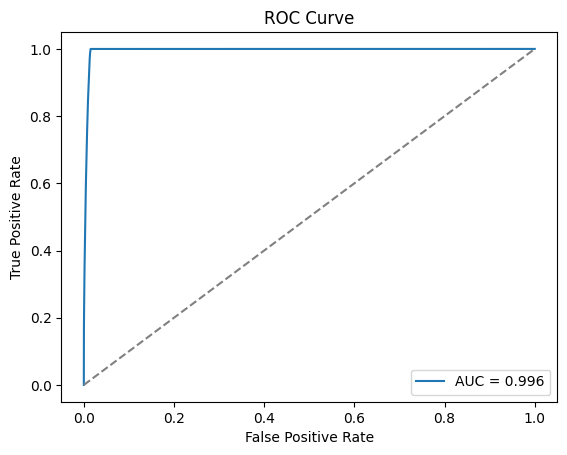

In [17]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [18]:
# # Preparar dados para treino final
# X_train = X
# y_train = y

# # Criar DMatrix do XGBoost (equivalente ao Dataset do LightGBM)
# final_train_data = xgb.DMatrix(X_train, label=y_train)


# # Treinar modelo final
# model = xgb.train(
#     params,
#     final_train_data,
#     verbose_eval=100  # Mostra progresso a cada 100 iterações
# )

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

In [20]:
# Starting new submission

test = pd.read_csv("/kaggle/input/data-challenge-2025-rnp/test.csv")
test["seconds_since_last_sample"] = test.groupby(["tr_dst", "tr_src"])["seconds_since_start"].diff().fillna(0)

filtered_test = test.copy()

In [21]:
filtered_test = filtered_test.sort_values(["tr_dst", "tr_src", "seconds_since_start"]).reset_index(drop=True)

# Normalize rtts for this test
import ast
def normalize_rtts(s):
    try:
        values = ast.literal_eval(s)   # parse "[...]" into a Python list
        if isinstance(values, (list, tuple)):
            return float(np.mean(values))  # mean if multiple, just the value if one
        else:
            return np.nan
    except Exception:
        return np.nan


filtered_test["norm_rtts"] = [normalize_rtts(x) for x in filtered_test["all_rtts"]]
filtered_test = filtered_test.drop("all_rtts", axis=1)

In [22]:
filtered_test["rtts_diff"] = filtered_test.groupby(["tr_dst", "tr_src"])["norm_rtts"].diff().abs().fillna(0)
filtered_test["rtts_diff_norm"] = filtered_test["rtts_diff"] / filtered_test["norm_rtts"]
filtered_test["ratio_replies_probes"] = filtered_test["total_probes_sent"] / filtered_test["total_replies_last_hop"]

filtered_test["ratio_rtts_diff_seconds"] = filtered_test["rtts_diff"] / filtered_test["seconds_since_last_sample"]


# Mapear valores históricos
filtered_test['route_change_rate'] = filtered_test.set_index(['tr_dst','tr_src']).index.map(route_stats)

# Preencher rotas não vistas com a média global do treino
filtered_test['route_change_rate'] = filtered_test['route_change_rate'].fillna(route_stats.mean())

filtered_test['rtts_mean_5'] = filtered_test.groupby(['tr_src','tr_dst'])['norm_rtts'].rolling(5, min_periods=1).mean().reset_index(level=[0,1], drop=True)
filtered_test['rtts_dist_from_mean_5'] = (filtered_test["rtts_mean_5"] - filtered_test["norm_rtts"]).abs()
filtered_test['rtts_mean'] = filtered_test.groupby(['tr_src','tr_dst'])['norm_rtts'].transform('mean')
filtered_test['rtts_dist_from_mean'] = (filtered_test["rtts_mean"] - filtered_test["rtts_diff"]).abs()

filtered_test['rtts_std'] = filtered_test.groupby(['tr_src', 'tr_dst'])['norm_rtts'].transform('std')
filtered_test['rtts_zscore'] = (filtered_test['norm_rtts'] - filtered_test['rtts_mean']) / (filtered_test['rtts_std'] + 1e-8)

filtered_test['rtts_rolling_std'] = filtered_test.groupby(['tr_src', 'tr_dst'])['norm_rtts'].transform(
    lambda x: x.rolling(window=10, min_periods=1).std()
)
# Preencher NaN com 0 e substituir zeros por um valor mínimo
filtered_test['rtts_rolling_std'] = filtered_test['rtts_rolling_std'].fillna(0)
filtered_test['rtts_rolling_std'] = filtered_test['rtts_rolling_std'].replace(0, filtered_test['rtts_rolling_std'][filtered_test['rtts_rolling_std'] > 0].min() if (filtered_test['rtts_rolling_std'] > 0).any() else 0.001)

filtered_test['rtts_sudden_change'] = (filtered_test['rtts_diff'] > filtered_test['rtts_rolling_std'] * 2).astype(int)

filtered_test["ratio_replies_probes"] = filtered_test["total_replies_last_hop"]  / filtered_test["total_probes_sent"]

# Calcula a distância absoluta de 1
filtered_test['ratio_dist1'] = np.abs(filtered_test['ratio_replies_probes'] - 1)

# Inverte para que valores próximos de 1 tenham maior valor
filtered_test['ratio_mono_dist1'] = 1 / (1 + filtered_test['ratio_dist1'])

In [23]:
answer_prob = model.predict(xgb.DMatrix(filtered_test[features]))
answer = (answer_prob > best_thresh).astype(int)

In [24]:
print((answer == 0).sum())
print((answer == 1).sum())

8276478
280019


In [25]:
filtered_test["route_changed"] = answer

In [26]:
check = filtered_test[["tr_id", "route_changed"]].copy()
check = check.rename(columns={'tr_id': 'id', 'route_changed': 'target'})

check.to_csv("/kaggle/working/submission.csv", index=False)

In [27]:
# #Finalizando

# test["route_changed"] = 0
# test.loc[test["seconds_since_last_sample"] > 0, "route_changed"] = answer
# test.loc[(test["seconds_since_last_sample"] > 0) & (test["route_changed"] == 1), "route_changed"]

In [28]:
# check = test[["tr_id", "route_changed"]].copy()
# check = check.rename(columns={'tr_id': 'id', 'route_changed': 'target'})

# check.to_csv("/kaggle/working/submission.csv", index=False)